# 2.8 Multi-Agent 시스템과 RouteLLM

- 앞에서 개발한 `소득세 에이전트`와 `종합부동산세 에이전트`를 활용해서 다중 에이전트 시스템을 구현합니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
)

small_llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-mini-2024-07-18',
    api_version='2024-08-01-preview',
)

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'."""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'llm']:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['income_tax', 'real_estate_tax', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})

    return route.target

In [5]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

- `node`를 추가하고 `edge`로 연결합니다
    - 앞에서 개발한 `agent`들을 `node`로 활용할 수 있습니다

In [6]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm'
    }
)
graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [8]:
graph = graph_builder.compile()

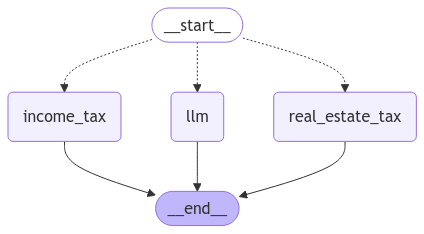

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_state = {'query': '소득세란 무엇인가요?'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='①조 세특례제한법, 또는 이 법 제12조에 따른 과세제외 소득  \n대통령령으로 정하는 임금소득(이하 “임금소득”이라 한다)과 근로소득  \n\n제12조제2항의 세호에 따라 원천징수하는 이자소득 및 배당소득과 제16조제1항제10호에 따른 직장공제회초 관련소득  \n\n\n법인으로 보는 단체 외의 단체 중 소득을 구성함에 배분하지 아니하는 단체로서 단체를 표기하는 금융거래를 하는 단체가 “금융신용기관” 및 비임금소득에 관한 법령이 제20조제1항 목의 이후에 해당하는 금융사업을 하는 단체(이하 “금융회사”等이란)로부터 받은 이자소득 및 배당소득  \n\n\n①조 세특례제한법에 따른 보통계소득  \n\n\n제30조부터 제35조까지의 규정 외의 이자소득과 배당소득(제17조제1항제8호에 따른 배당소득을 제외한다)으로서 그 소득의 합계액이 2천만원(이하 “이자소득의 종합세액기준금액”이라 한다) 이하인 경우 제17조에 따른 원천징수된 소득  \n\n\n해당 과세기간에 배당행정을 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(이하 “분리과세 주택임대소득”이라 한다). 이 경우 주택임대소득이 산정 등에 필요한 대책행령으로 정한다.  \n\n\n다음 각 목 외의 기타소득(이하 “분리과세 기타소득”이라 한다)  \n\n\n가. 제21조제1항제3호 제4항, 제19조, 제20조제1항, 제22조제2항, 제26조 및 제26조의2 및 제 127조에 따라 원천징수(제21조제19항에 의하여 원천징수되지 아니하는 경우를 포함한다) 소득. 다만, 해당 소득이 있는 거주자가 종합소득과세표준을 계산해 고소득을 합산하는 경우 그 소득은 분리과세로 세액계산에 제외한다.  \n나. 제21조제19항제2조 및 같은 조 제2항에 따른 기타소득  \n다. 제21조제19항제20호에 따른 기타소득 중 복리복리금, 제20조 제3회 복리 당정\n마. 

{'query': '소득세란 무엇인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='①조 세특례제한법, 또는 이 법 제12조에 따른 과세제외 소득  \n대통령령으로 정하는 임금소득(이하 “임금소득”이라 한다)과 근로소득  \n\n제12조제2항의 세호에 따라 원천징수하는 이자소득 및 배당소득과 제16조제1항제10호에 따른 직장공제회초 관련소득  \n\n\n법인으로 보는 단체 외의 단체 중 소득을 구성함에 배분하지 아니하는 단체로서 단체를 표기하는 금융거래를 하는 단체가 “금융신용기관” 및 비임금소득에 관한 법령이 제20조제1항 목의 이후에 해당하는 금융사업을 하는 단체(이하 “금융회사”等이란)로부터 받은 이자소득 및 배당소득  \n\n\n①조 세특례제한법에 따른 보통계소득  \n\n\n제30조부터 제35조까지의 규정 외의 이자소득과 배당소득(제17조제1항제8호에 따른 배당소득을 제외한다)으로서 그 소득의 합계액이 2천만원(이하 “이자소득의 종합세액기준금액”이라 한다) 이하인 경우 제17조에 따른 원천징수된 소득  \n\n\n해당 과세기간에 배당행정을 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(이하 “분리과세 주택임대소득”이라 한다). 이 경우 주택임대소득이 산정 등에 필요한 대책행령으로 정한다.  \n\n\n다음 각 목 외의 기타소득(이하 “분리과세 기타소득”이라 한다)  \n\n\n가. 제21조제1항제3호 제4항, 제19조, 제20조제1항, 제22조제2항, 제26조 및 제26조의2 및 제 127조에 따라 원천징수(제21조제19항에 의하여 원천징수되지 아니하는 경우를 포함한다) 소득. 다만, 해당 소득이 있는 거주자가 종합소득과세표준을 계산해 고소득을 합산하는 경우 그 소득은 분리과세로 세액계산에 제외한다.  \n나. 제21조제19항제2조 및 같은 조 제2항에 따른 기타소득  \n다. 제21조제19항제20호에 따른 기타소득 중 

In [11]:
initial_state = {
    'query': '집 15억은 세금을 얼마나 내나요?'
}

graph.invoke(initial_state)

tax_base == 주어진 정보를 바탕으로 사용자의 집에 대한 과세표준을 계산하고, 대략적인 과세 금액을 추정할 수 있습니다. 하지만, 종합부동산세는 과세표준에 세율을 적용해 계산되며, 세율은 과세표준 구간에 따라 누진적으로 적용됩니다. 여기서는 과세표준을 계산하는 과정만 설명드리며, 세율에 대한 정보는 제공되지 않았으므로 과세 금액은 추정하지 않겠습니다.

---

### **1. 주어진 정보**
- **주택 공시가격**: 15억 원
- **공제금액**:
  - 1세대 1주택자: 12억 원
  - 일반 납세자: 9억 원
  - 법인 또는 법인으로 보는 단체: 6억 원
- **공정시장가액비율**: 60% (추정)

---

### **2. 과세표준 계산**
과세표준 계산 공식:

\[
\text{과세표준} = (\text{공시가격} - \text{공제금액}) \times \text{공정시장가액비율}
\]

**(1) 1세대 1주택자 (공제금액 12억 원)**
\[
\text{과세표준} = (15억 - 12억) \times 60\%
\]
\[
\text{과세표준} = 3억 \times 60\% = 1.8억 원
\]

**(2) 일반 납세자 (공제금액 9억 원)**
\[
\text{과세표준} = (15억 - 9억) \times 60\%
\]
\[
\text{과세표준} = 6억 \times 60\% = 3.6억 원
\]

**(3) 법인 또는 법인으로 보는 단체 (공제금액 6억 원)**
\[
\text{과세표준} = (15억 - 6억) \times 60\%
\]
\[
\text{과세표준} = 9억 \times 60\% = 5.4억 원
\]

---

### **3. 결과 요약**
- **1세대 1주택자**: 과세표준 1.8억 원
- **일반 납세자**: 과세표준 3.6억 원
- **법인 또는 법인으로 보는 단체**: 과세표준 5.4억 원

---

### **4. 주의**
위 계산은 **공정시장가액비율을 60%로 가정**하여 추정한 결과입니다. 실제 공정시장가액비

{'query': '집 15억은 세금을 얼마나 내나요?',
 'answer': '주택 공시가격이 15억 원이고, 주택 소유자 유형 및 주택 수에 따라 공제금액과 세율이 달라집니다. 아래에서 과세표준을 계산하고, 세율을 적용하여 종합부동산세를 산출하겠습니다. 계산은 **1세대 1주택자**, **2주택 이하 소유자(일반 납세자)**, **법인 또는 3주택 이상 소유자**로 나누어 진행합니다.\n\n---\n\n### **1. 가정**\n- **주택 공시가격**: 15억 원\n- **공정시장가액비율**: 60% (2023년 기준)\n- **공제금액**:\n  - 1세대 1주택자: 12억 원\n  - 일반 납세자: 9억 원\n  - 법인 또는 3주택 이상 소유자: 6억 원\n\n---\n\n### **2. 과세표준 계산**\n과세표준 계산 공식:\n\\[\n\\text{과세표준} = (\\text{공시가격} - \\text{공제금액}) \\times \\text{공정시장가액비율}\n\\]\n\n#### (1) 1세대 1주택자:\n\\[\n\\text{과세표준} = (15억 - 12억) \\times 60\\% = 3억 \\times 60\\% = 1.8억 원\n\\]\n\n#### (2) 일반 납세자:\n\\[\n\\text{과세표준} = (15억 - 9억) \\times 60\\% = 6억 \\times 60\\% = 3.6억 원\n\\]\n\n#### (3) 법인 또는 3주택 이상 소유자:\n\\[\n\\text{과세표준} = (15억 - 6억) \\times 60\\% = 9억 \\times 60\\% = 5.4억 원\n\\]\n\n---\n\n### **3. 세율 적용 및 종합부동산세 계산**\n세율은 과세표준 구간에 따라 다음과 같이 적용됩니다.\n\n#### (1) 1세대 1주택자 (과세표준 1.8억 원)\n- 1.8억 원은 **3억 원 이하** 구간에 속하므로:\n\\[\n\\text{세액} = 1.8억 × 0.5\\% = 90만 원\n\\]\n\n###

In [12]:
initial_state = {'query': '떡볶이는 어디가 맛있나요?'}
graph.invoke(initial_state)

{'query': '떡볶이는 어디가 맛있나요?',
 'answer': '떡볶이는 한국의 대표적인 길거리 음식으로, 많은 곳에서 맛있는 떡볶이를 찾을 수 있습니다. 지역마다 유명한 떡볶이 가게가 다르지만, 몇 군데 추천해드릴게요.\n\n1. **신당동 떡볶이**: 서울의 신당동은 떡볶이 골목으로 유명합니다. 여러 가게에서 다양한 스타일의 떡볶이를 맛볼 수 있습니다.\n\n2. **이태원**: 이태원에도 맛있는 떡볶이 가게가 많습니다. 특히 외국인 관광객들에게도 인기가 높습니다.\n\n3. **부산**: 부산의 자갈치 시장 근처에는 해산물 떡볶이로 유명한 가게들이 있습니다. 매콤한 떡볶이를 해산물과 함께 즐길 수 있습니다.\n\n4. **전주**: 전주 한옥마을 주변에도 맛있는 떡볶이 가게가 많습니다. 전통적인 맛을 느낄 수 있는 곳이 많습니다.\n\n각 지역마다 특색 있는 떡볶이를 맛볼 수 있으니, 방문하는 지역에 따라 다양한 떡볶이를 즐겨보세요!'}